In [1]:
# Clone from GitHub to Colab
!pip install ipynb # to import functions from other ipynb files
!git clone https://github.com/peepkolberg/CNS-EOG-classifier.git

%cd CNS-EOG-classifier/

Cloning into 'CNS-EOG-classifier'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 62 (delta 8), reused 15 (delta 5), pack-reused 43
Unpacking objects: 100% (62/62), done.
/content/CNS-EOG-classifier


Looks good! All datasets contain all classes.
Total 16 datasets.

Columns and their data types: 
time_sec               int32
time_microsec          int32
time_full            float64
signal_horizontal      int32
signal_vertical        int32
class                  int32
dtype: object

participant:1   experiment:0   total rows:97742
		     class:1   nr of rows:16299
		     class:2   nr of rows:6706
		     class:3   nr of rows:15014
		     class:4   nr of rows:23494
		     class:5   nr of rows:8977
		     class:6   nr of rows:25065
		     class:7   nr of rows:398
		     class:8   nr of rows:1789

participant:1   experiment:1   total rows:157976
		     class:1   nr of rows:10308
		     class:2   nr of rows:30140
		     class:3   nr of rows:30717
		     class:4   nr of rows:8526
		     class:5   nr of rows:35512
		     class:6   nr of rows:38634
		     class:7   nr of rows:1968
		     class:8   nr of rows:2171

participant:2   experiment:0   total rows:221051
		     class:1   nr of rows:30

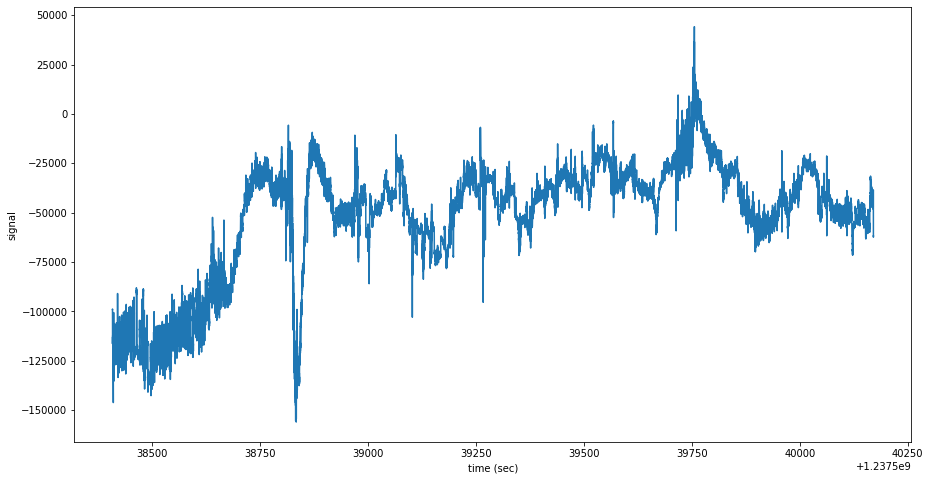

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ipynb.fs.full.preprocess import read_all_files # import the function to read .mat data into DataFrame

from tensorflow.keras.optimizers import Adam

In [3]:
def data_split(df, chunk_size):
  """
  Input: DataFrame
  Outputs: NumPy arrays of data and labels

  Splits time-series data into equal-sized chunks. 
  """

  X = []
  y = []

  for label in df['class'].unique():
    class_df = df[df['class'] == label]

    signals = []

    for sig_h, sig_v in zip(class_df['signal_horizontal'], class_df['signal_vertical']):
      signals.append(np.asarray((sig_h, sig_v)))

    signals = np.asarray(signals)

    for i in range(0, len(signals), chunk_size): 
      X.append(np.asarray(signals[i:i + chunk_size]))
      y.append(label)

    # Deleting the last chunk if it's not of required size
    if len(X[-1]) != chunk_size:
      #print(f"last chunk in label {label} not of size 398, but {len(X[-1])}")
      del X[-1]
      del y[-1]

  return np.asarray(X), np.asarray(y) - 1 # Subtracting 1 because keras tools expect numerical labels to start from 0

def split_datasets(datasets_dict):
  """ Splits each dataset into chunks of size 398. """

  for participant, exps in datasets_dict.items():
    for experiment, data in exps.items():
      #print(f"starting participant {participant} experiment {experiment}")
      X, y = data_split(data, 398)
      #print(f"got total {len(X)} chunks, {len(y)} labels")
      datasets_dict[participant][experiment] = {'X': X, 'y': y} # <-- To also rename labels to their corresponding words, use rename_labels(y) instead of y

def rename_labels(numerical_labels):
  replacements = {0: 'null', 
                  1: 'read', 
                  2: 'browse', 
                  3: 'write', 
                  4: 'video', 
                  5: 'copy', 
                  6: 'disspeak', 
                  7: 'disphone'}
  return np.asarray([replacements[old_label] for old_label in numerical_labels])

def concat_datasets(datasets_dict, participants):
  X = []
  y = []

  for p in participants:
    for e in (0, 1):
      X.append(datasets_dict[p][e]['X'])
      y.append(datasets_dict[p][e]['y'])

  X = np.concatenate(X)
  y = np.concatenate(y)
  
  return X, y

In [4]:
from tensorflow.keras.utils import to_categorical

def one_hot_encode_labels(datasets_dict):
  for p, exps in datasets_dict.items():
    for e, data in exps.items():
      data['y'] = to_categorical(data['y'])

def print_data_dimensions(datasets_dict):
  total_chunks = 0
  total_labels = 0
  for participant, experiments in datasets_dict.items():
    for experiment, data in experiments.items():
      print(f"participant:{participant}   experiment:{experiment}")
      print(f"signals shape:{data['X'].shape}")
      print(f" labels shape:{data['y'].shape}")
      total_chunks += data['X'].shape[0]
      total_labels += data['y'].shape[0]

  print(f"\nTotal {total_chunks} chunks and {total_labels} labels (check that they're equal).")

# Read files into dataframes (see function description in preprocess.ipynb for details)
datasets_dict = read_all_files()

# Split each class in dataset into chunks of size 398.
# Because the smallest class in any dataset had 398 rows.
#
# Doesn't do this at the moment --> Also renames class labels from numbers to their names: 1 -> 'null', 2 -> 'read', 3 -> 'browse', etc
split_datasets(datasets_dict)

# One-hot encode labels
one_hot_encode_labels(datasets_dict)

# Print the final dimensions of each dataset
print_data_dimensions(datasets_dict)

participant:1   experiment:0
signals shape:(241, 398, 2)
 labels shape:(241, 8)
participant:1   experiment:1
signals shape:(393, 398, 2)
 labels shape:(393, 8)
participant:2   experiment:0
signals shape:(552, 398, 2)
 labels shape:(552, 8)
participant:2   experiment:1
signals shape:(286, 398, 2)
 labels shape:(286, 8)
participant:3   experiment:0
signals shape:(552, 398, 2)
 labels shape:(552, 8)
participant:3   experiment:1
signals shape:(560, 398, 2)
 labels shape:(560, 8)
participant:4   experiment:0
signals shape:(499, 398, 2)
 labels shape:(499, 8)
participant:4   experiment:1
signals shape:(491, 398, 2)
 labels shape:(491, 8)
participant:5   experiment:0
signals shape:(526, 398, 2)
 labels shape:(526, 8)
participant:5   experiment:1
signals shape:(453, 398, 2)
 labels shape:(453, 8)
participant:6   experiment:0
signals shape:(533, 398, 2)
 labels shape:(533, 8)
participant:6   experiment:1
signals shape:(468, 398, 2)
 labels shape:(468, 8)
participant:7   experiment:0
signals sha

In [11]:
# Testing CNN

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Input, LayerNormalization, BatchNormalization, GlobalAveragePooling1D

def compile_model(input_shape):
  model = Sequential()

  model.add(Input(shape = input_shape))
  model.add(LayerNormalization(axis=1)) # This should normalize across each feature (not each sample).

  model.add(Conv1D(16, 3, padding="same", activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(Conv1D(32, 5, padding="same", activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(Conv1D(64, 7, padding="same", activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling1D())

  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


# For each test, one participant is the test participant (not included in the training set)

results = {} # Save the histories of testing participant

for testing_participant in range(1, 9):
  print(f"starting testing participant {testing_participant}")
  training_participants = list(range(1, 9))
  training_participants.remove(testing_participant)
  
  X_train, y_train = concat_datasets(datasets_dict, training_participants)
  X_test, y_test = concat_datasets(datasets_dict, [testing_participant])

  #print(X_train.shape, y_train.shape)
  #print(X_test.shape, y_test.shape, '\n')

  # Makes a fresh model for every person
  model = compile_model(input_shape = X_train.shape[1:])
  #model.summary()

  results[testing_participant] = model.fit(X_train, y_train, batch_size = 16, epochs=20, validation_data = (X_test, y_test))
  print()

starting testing participant 1
Epoch 1/20
426/426 [==============================] - 7s 12ms/step - loss: 1.8803 - accuracy: 0.2255 - val_loss: 1.8598 - val_accuracy: 0.1735
Epoch 2/20
426/426 [==============================] - 5s 12ms/step - loss: 1.7639 - accuracy: 0.2944 - val_loss: 2.2488 - val_accuracy: 0.1987
Epoch 3/20
426/426 [==============================] - 5s 12ms/step - loss: 1.6587 - accuracy: 0.3431 - val_loss: 1.7636 - val_accuracy: 0.2886
Epoch 4/20
426/426 [==============================] - 5s 12ms/step - loss: 1.5759 - accuracy: 0.3785 - val_loss: 1.6843 - val_accuracy: 0.3170
Epoch 5/20
426/426 [==============================] - 5s 12ms/step - loss: 1.5133 - accuracy: 0.4110 - val_loss: 1.5418 - val_accuracy: 0.3691
Epoch 6/20
426/426 [==============================] - 5s 12ms/step - loss: 1.4501 - accuracy: 0.4482 - val_loss: 1.6228 - val_accuracy: 0.3880
Epoch 7/20
426/426 [==============================] - 5s 12ms/step - loss: 1.3895 - accuracy: 0.4795 - val_loss